In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import re
import gc
import os
import sys
import json

from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.style as style
style.use('seaborn-whitegrid')

sys.path.append("/" + os.path.join(*os.path.dirname(os.getcwd()).split("/") + ["utils"]))
import raw_signal_utils
import peptide_segmentation as pepseg
from yaml_assistant import YAMLAssistant
import peptide_filter_utils as pepfilter
import peptide_quantifier_utils as pepquant

# Load run configuration

In [3]:
date = "20210118"
flowcell = "FAP26604"
config_file = os.path.join(os.path.dirname(os.getcwd()), "nanopore_experiments", "configs", "segment_%s_%s.yml" % (date, flowcell))

## Parse multi-experiment fast5 file

Splits bulk fast5 based on run partitions. Make sure to change temp file name if running multiple experiment notebooks in parallel so they will not overwrite each other!

In [4]:
raw_signal_utils.split_multi_fast5(config_file, temp_f5_fname="temp2.f5")

Preparing a template fast5 file for run03 splits.
Copying the template for each split and adding metadata.
Split: run03_a
Splitting fast5, processing one channel at a time.
    Channel_1
    Channel_2
    Channel_3
    Channel_4
    Channel_5
    Channel_6
    Channel_7
    Channel_8
    Channel_9
    Channel_10
    Channel_11
    Channel_12
    Channel_13
    Channel_14
    Channel_15
    Channel_16
    Channel_17
    Channel_18
    Channel_19
    Channel_20
    Channel_21
    Channel_22
    Channel_23
    Channel_24
    Channel_25
    Channel_26
    Channel_27
    Channel_28
    Channel_29
    Channel_30
    Channel_31
    Channel_32
    Channel_33
    Channel_34
    Channel_35
    Channel_36
    Channel_37
    Channel_38
    Channel_39
    Channel_40
    Channel_41
    Channel_42
    Channel_43
    Channel_44
    Channel_45
    Channel_46
    Channel_47
    Channel_48
    Channel_49
    Channel_50
    Channel_51
    Channel_52
    Channel_53
    Channel_54
    Channel_55
    Channel

    Channel_509
    Channel_510
    Channel_511
    Channel_512
Closing and compressing files.
Backing up the config file to /ssd1/home/kz9/dna-nanopore-computing/nanopore_experiments/configs/segment_20210118_FAP26604.backup.20211123-2257.yml
Saving new filenames to config file.
Done


In [5]:
y = YAMLAssistant(config_file)

## What's in these runs?

Plots example traces from each run partition.

In [6]:
plt.ioff()
show_plot_here = True
fast5_dir = y.get_variable("fast5:dir")
fast5_prefix = y.get_variable("fast5:prefix")
fast5_fnames = y.get_variable("fast5:names")

run03_a.Channel_1


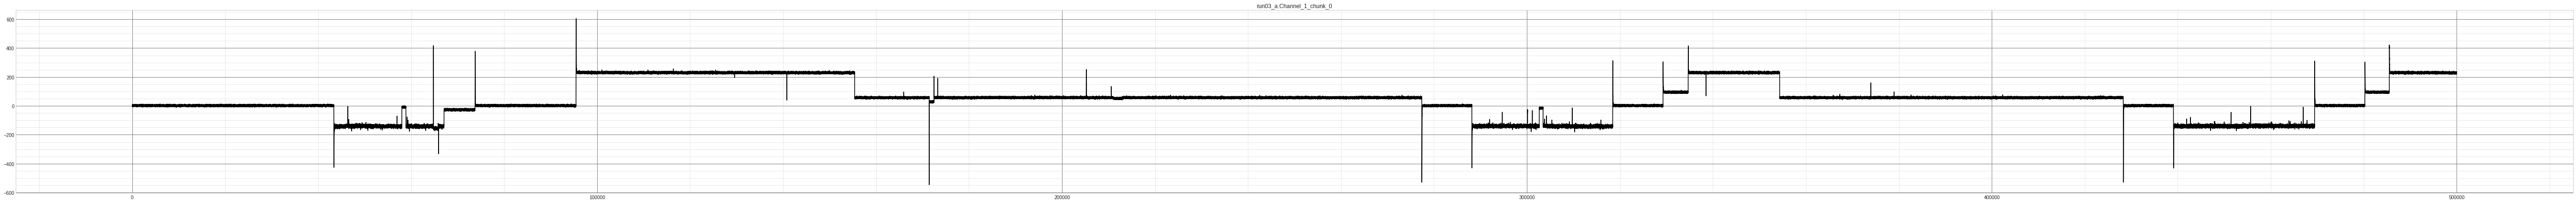

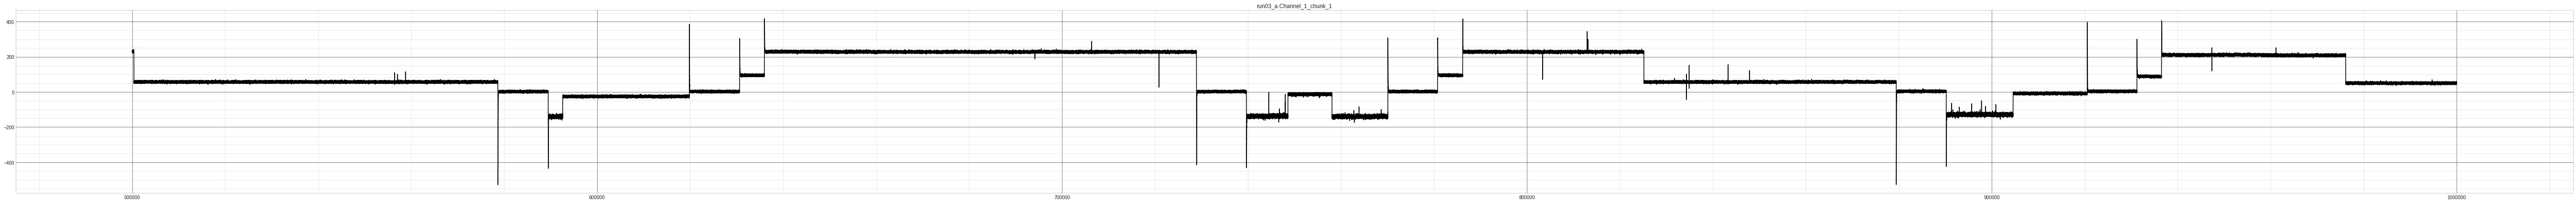

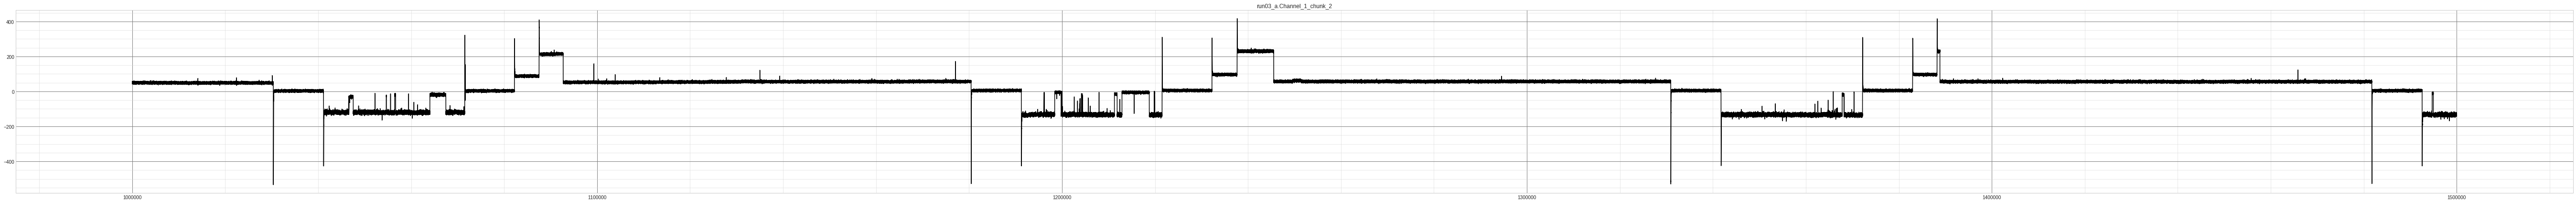

run03_a.Channel_2


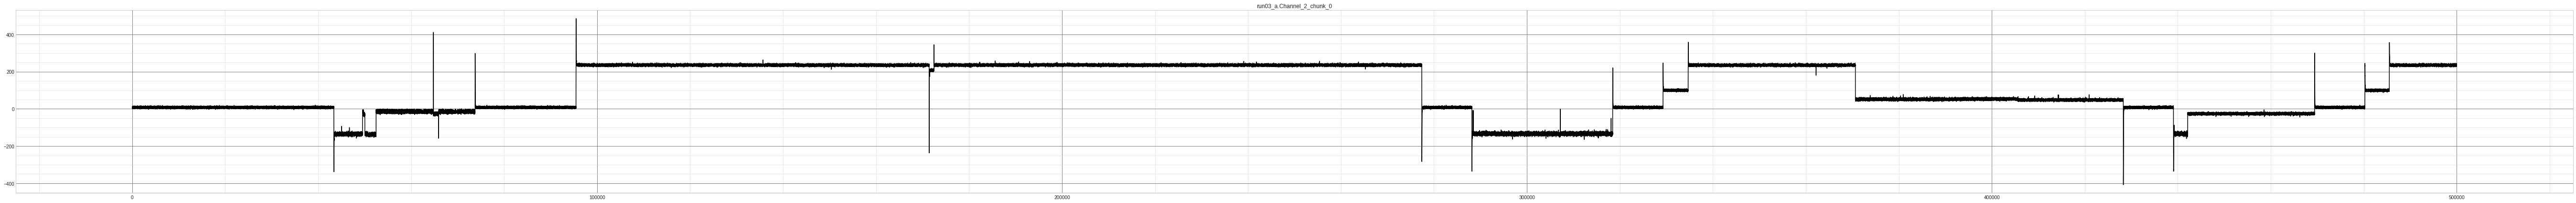

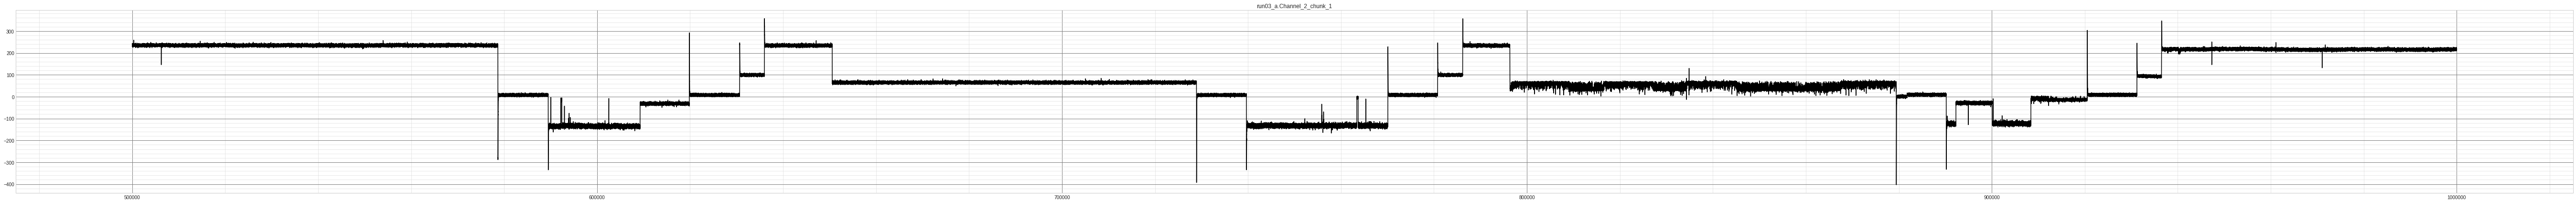

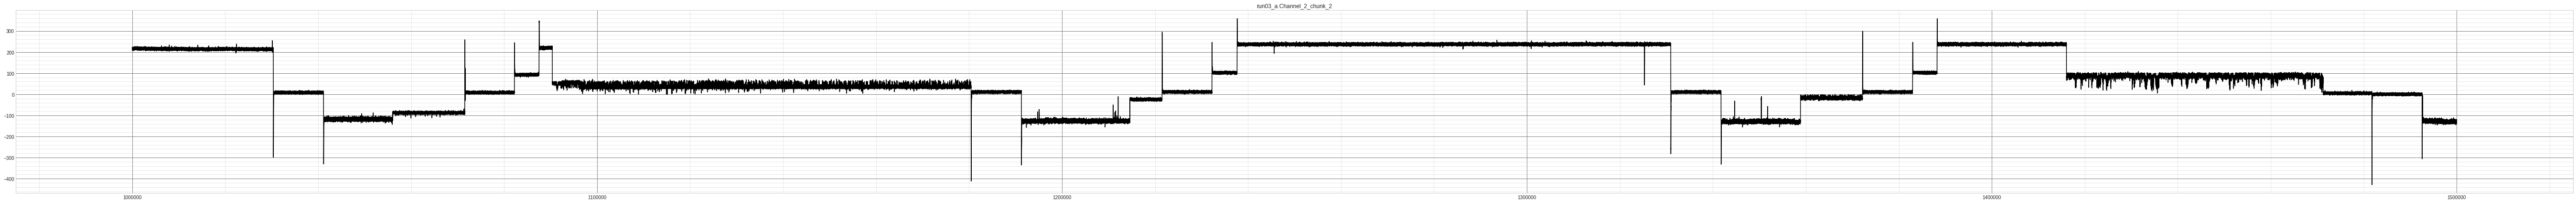

run03_a.Channel_3


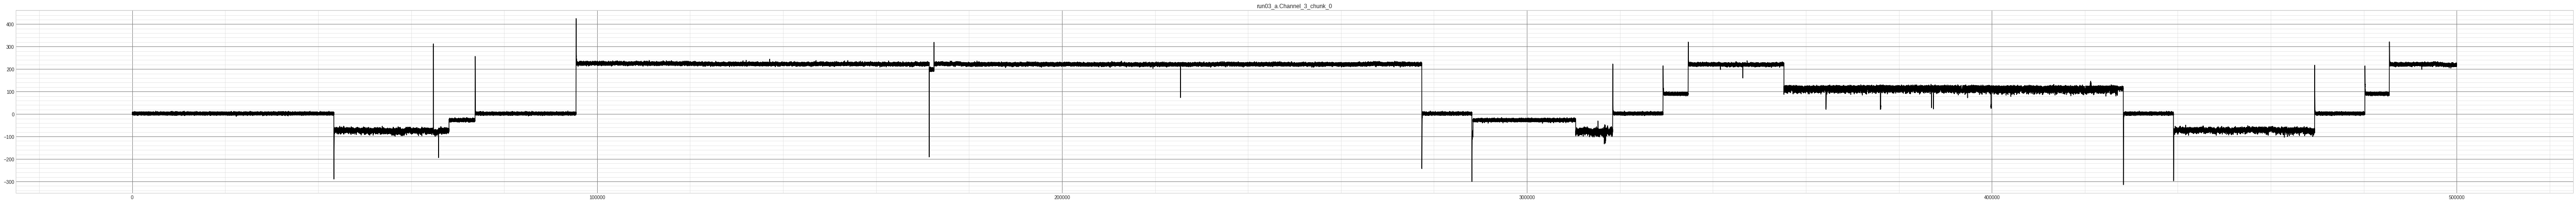

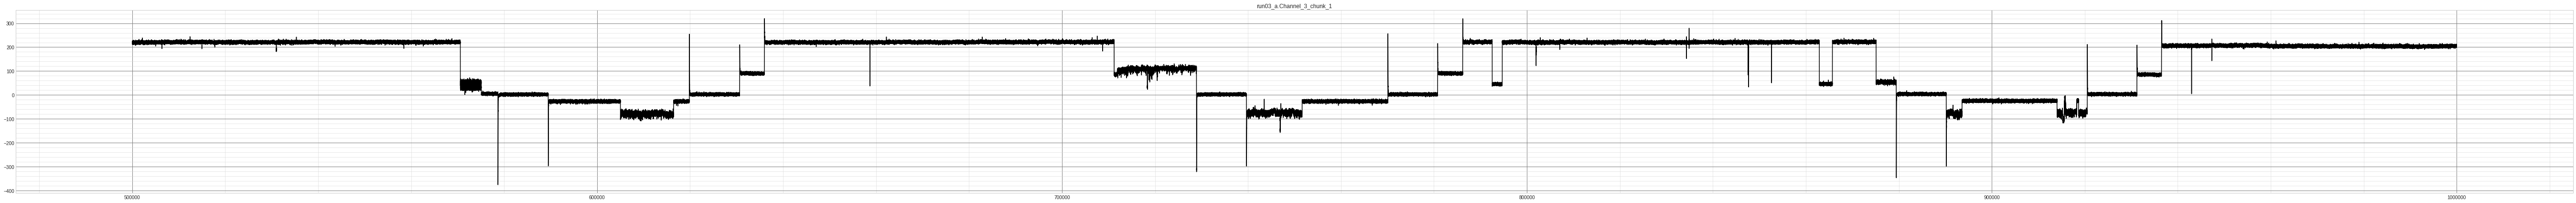

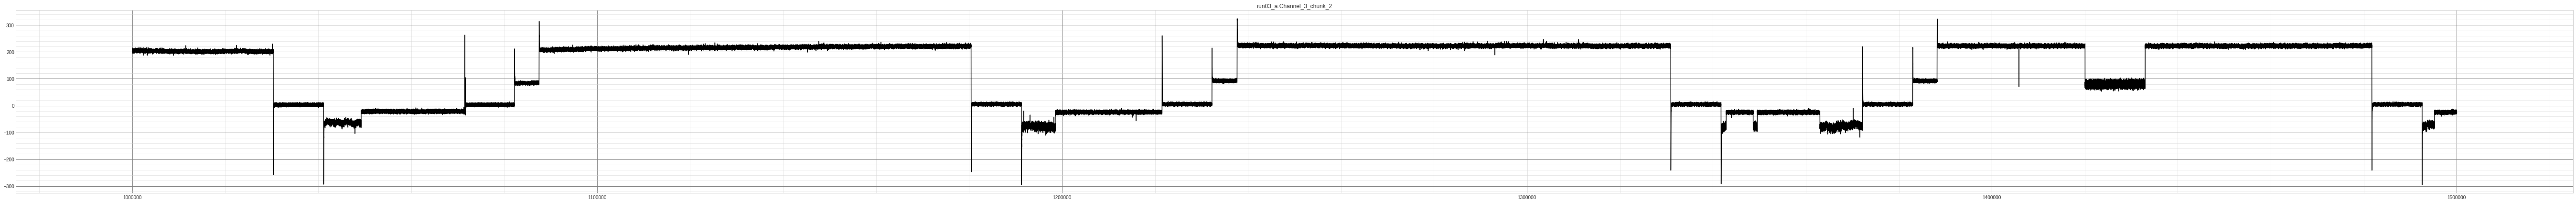

run03_a.Channel_4
run03_a.Channel_5


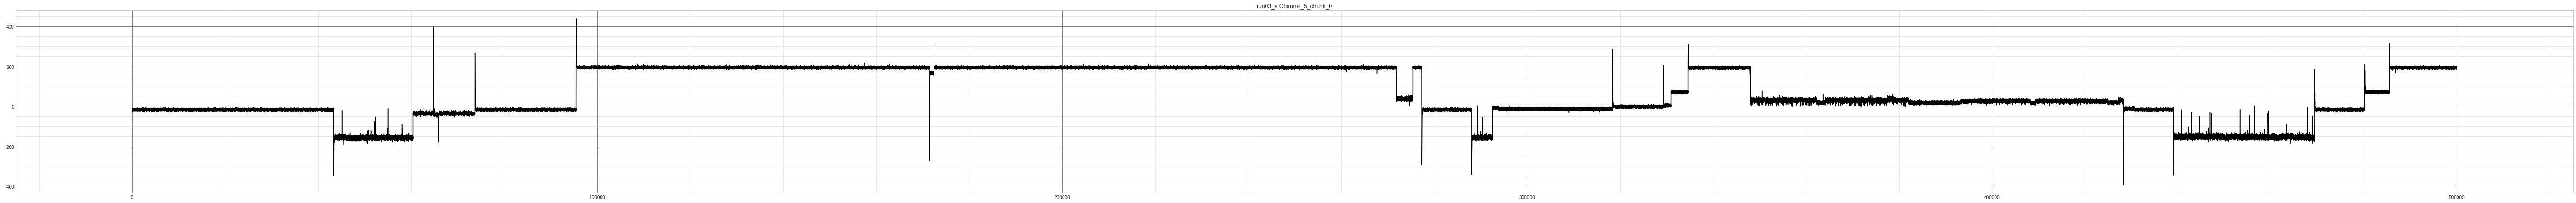

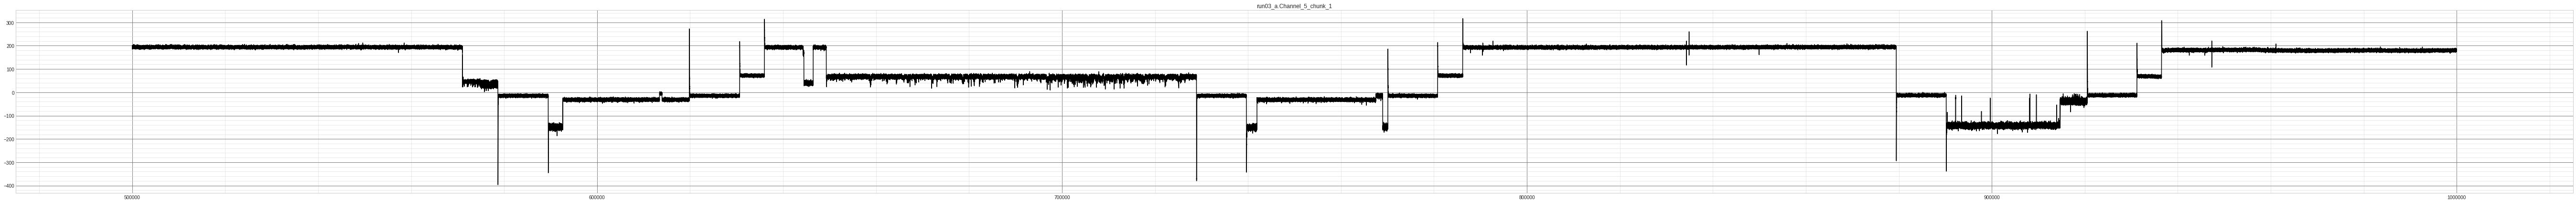

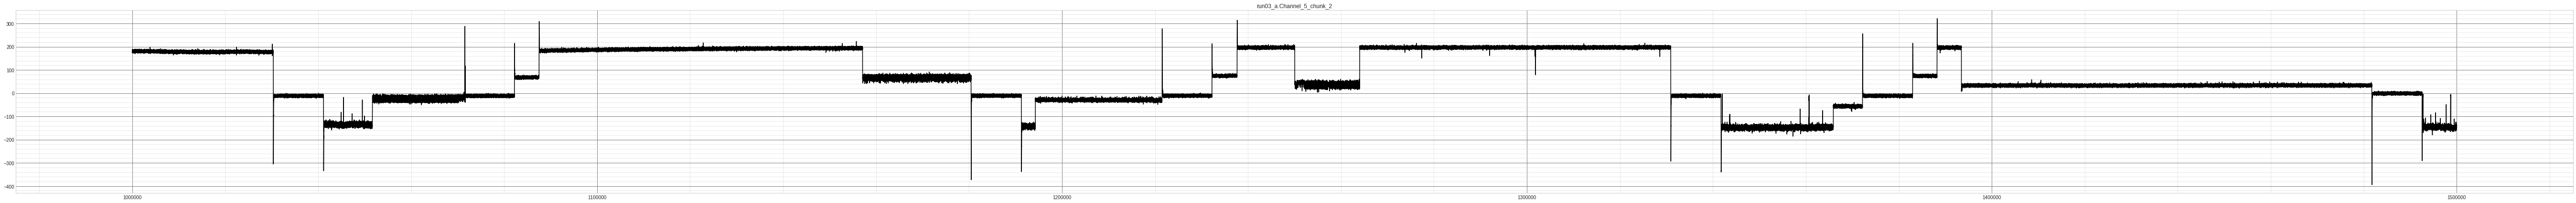

run03_a.Channel_6
run03_a.Channel_7


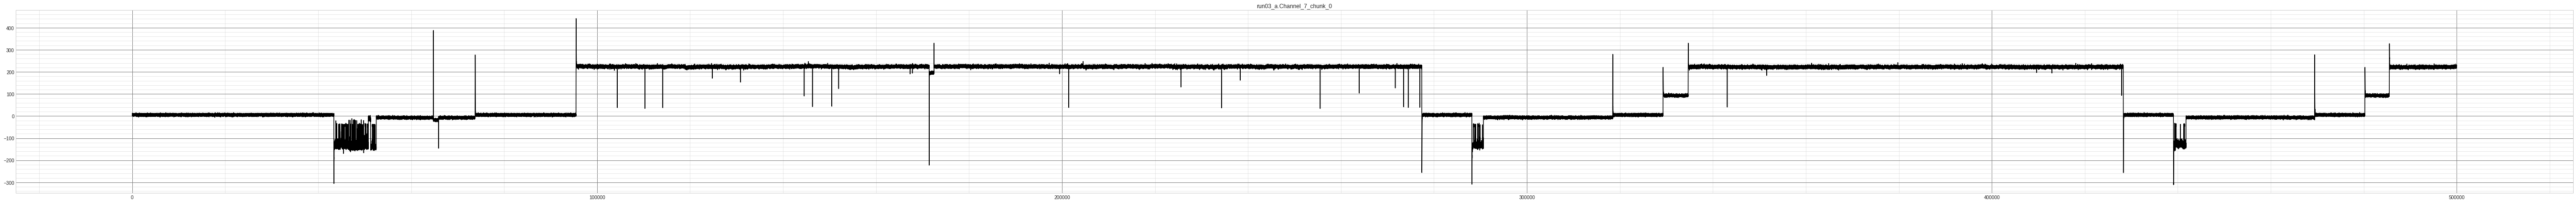

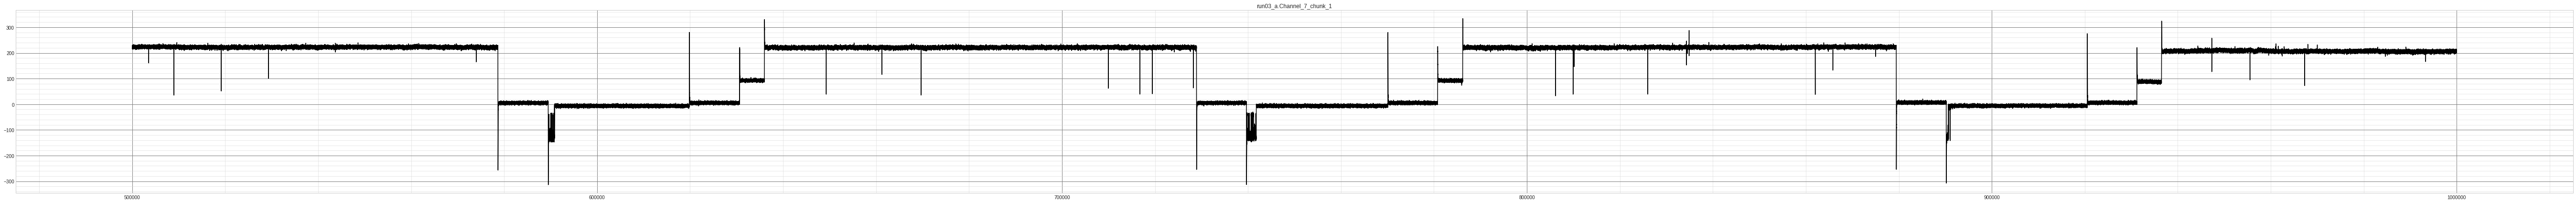

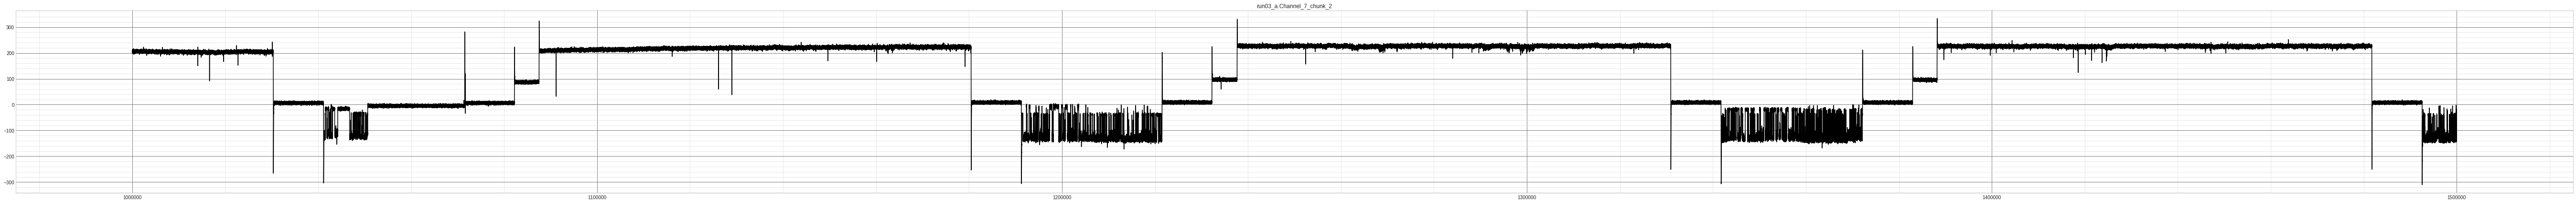

run03_a.Channel_8
run03_a.Channel_9
run03_a.Channel_10


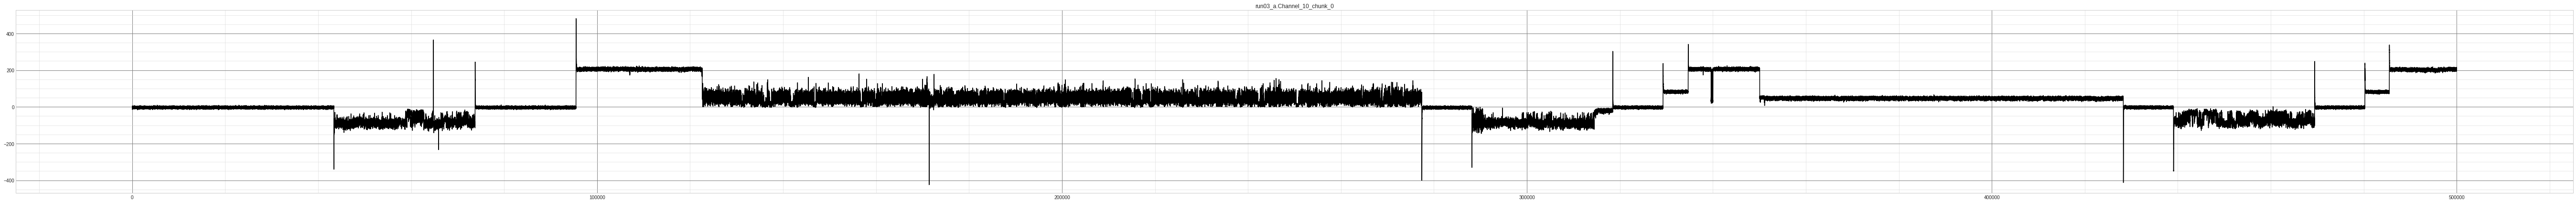

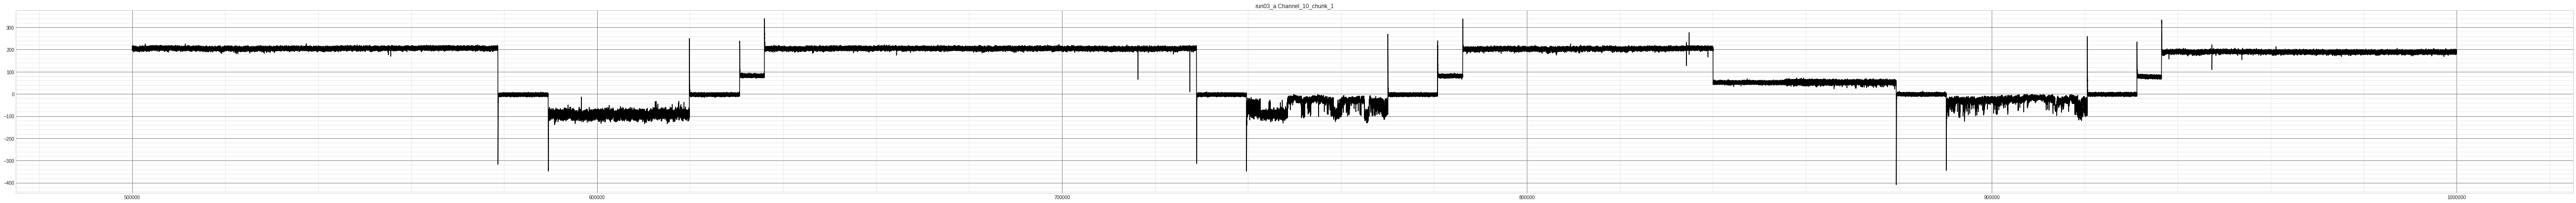

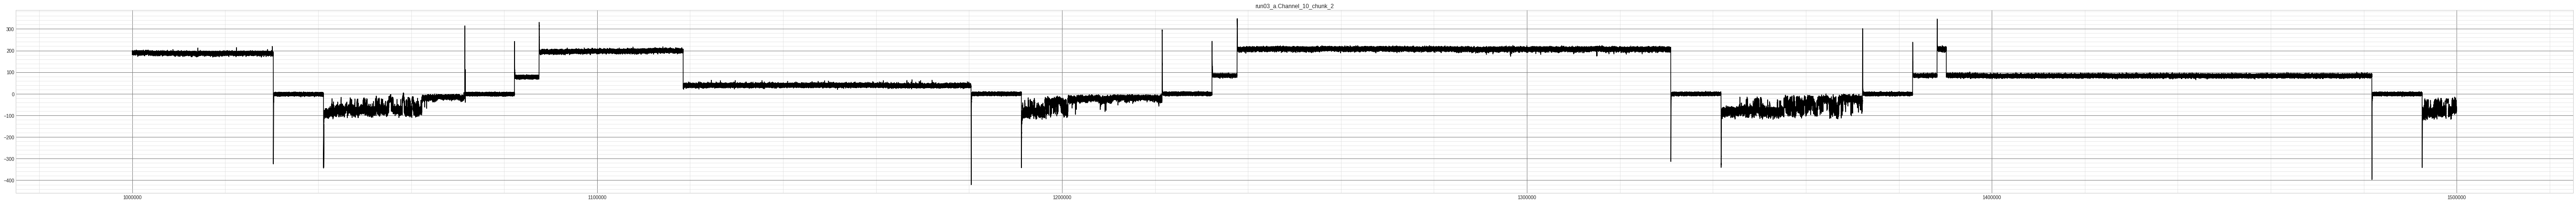

In [7]:
try:
    os.makedirs("plots/%s/raw" % date)
except:
    pass

for run, fast5_fname in sorted(fast5_fnames.items()):
    f5 = h5py.File(os.path.join(fast5_dir, fast5_prefix + fast5_fname))
    channels_present = [int(re.findall(r"Channel_(\d+)", str(x))[0])
                        for x in f5.get("/Raw").values()]
    for channel_no in sorted(channels_present)[:10]:
        channel = "Channel_%s" % str(channel_no)
        signal = raw_signal_utils.get_scaled_raw_for_channel(
            f5, channel=channel)
        source = run + "." + channel
        print(source)
        if np.std(signal) < 50:
            continue

        for chunk_i, chunk_start in enumerate(range(0, len(signal), 500000)[:3]):
            chunk_end = np.min([len(signal), chunk_start + 500000])
            fig, ax = plt.subplots(figsize=(75, 6))
            ax.plot(range(chunk_start, chunk_end),
                    signal[chunk_start:chunk_end], color="black")
            ax.set_title(source + "_chunk_%d" % chunk_i)
            ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())
            ax.grid(b=True, which='major', color='grey', linewidth=1.0)
            ax.grid(b=True, which='minor', color='lightgrey', linewidth=0.5)
            fig.tight_layout()
            if show_plot_here:
                plt.show()
            try:
                fig.savefig("plots/%s/raw/%s_%s_%s_chunk_%d.png" %
                            (date, date, run, channel, chunk_i))
            except OverflowError:
                pass
            fig.clf()
            plt.close()
            gc.collect()
plt.ion()

# Find good channels

Writes good channels to config file.

/disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Finding good channels in run03_a.
Writing good channels to yaml file.
Plotting channel status.


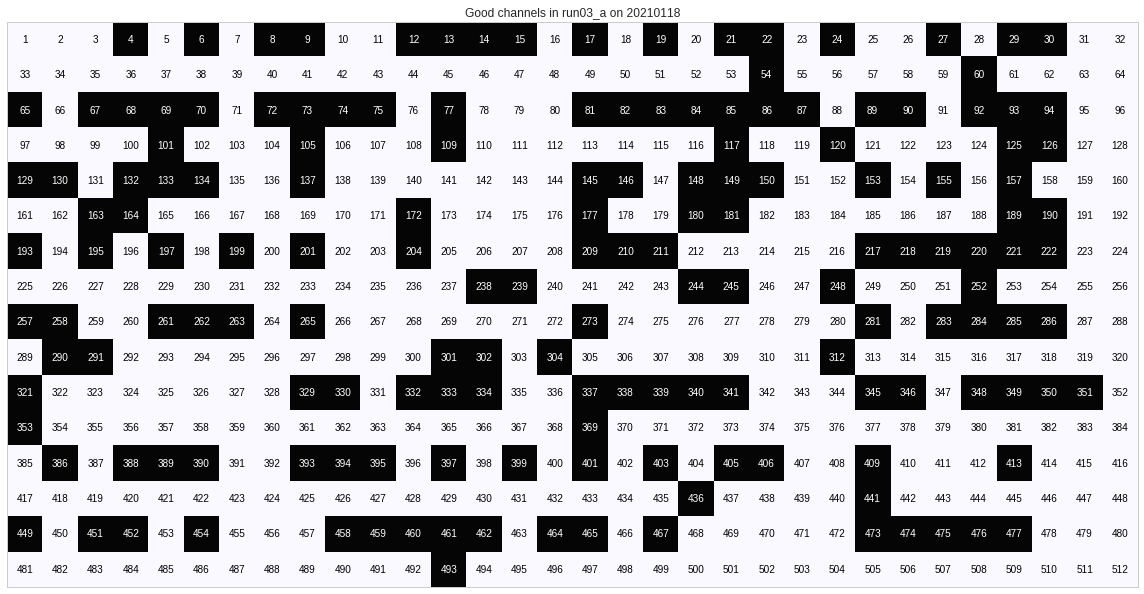

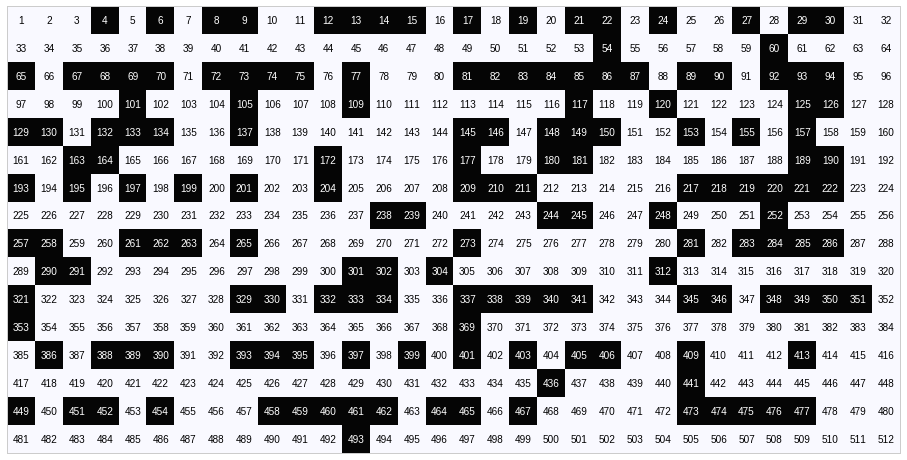

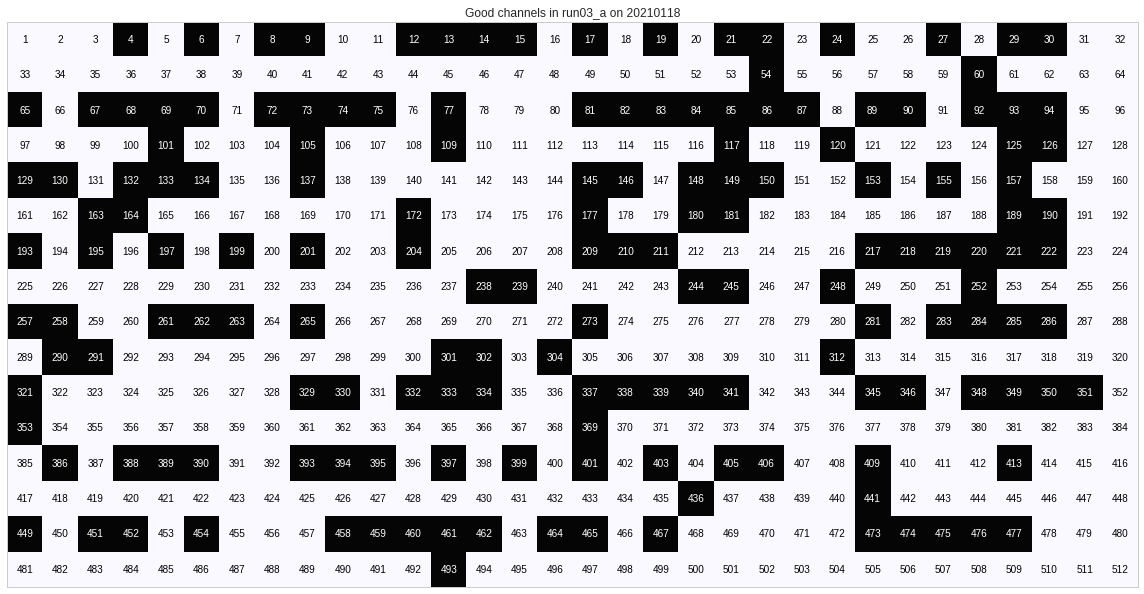

In [8]:
signal_priors = y.get_variable("segmentation_params:signal_priors")
prior_open_pore = signal_priors.get("prior_open_pore_mean")
prior_open_pore_std = signal_priors.get("prior_open_pore_std")

from raw_signal_utils import make_cmap
cmap = make_cmap([(0.02, 0.02, 0.02), (0.7, 0.7, 0.7), (0.98, 0.98, 1)])

try:
    os.makedirs("plots/%s/qc/" % date)
except:
    pass

# Redetermine good channels if needed
for i, (run, name) in enumerate(fast5_fnames.items()):
    f5_fname = fast5_dir + "/" + fast5_prefix + name
    print(f5_fname)
    print("Finding good channels in %s." % (run))
    channel_grid, good_channels = raw_signal_utils.judge_channels(f5_fname, expected_open_pore=None, plot_grid=True)
    print("Writing good channels to yaml file.")
    good_channels = [int(c) for c in good_channels]
    y.write_variable("fast5:good_channels:%s" % (run), good_channels)
    print("Plotting channel status.")
    fig, _ = raw_signal_utils.plot_channel_grid(channel_grid, cmap,
                title="Good channels in %s on %s" % (run, date),
                cbar_minmax=(0, None))
    fig.tight_layout()
    fig.savefig("plots/%s/qc/%s_%s_good_channels.png" %
                            (date, date, run))
    display(fig)

In [9]:
y = YAMLAssistant(config_file)

# Find peptides

In [10]:
open_pore_prior = y.get_variable("segmentation_params:signal_priors:prior_open_pore_mean")
open_pore_prior_std = y.get_variable("segmentation_params:signal_priors:prior_open_pore_std")
good_channels = y.get_variable("fast5:good_channels")

In [11]:
fast5_fnames_full = fast5_fnames.copy()
for run, fname in fast5_fnames_full.items():
    fast5_fnames_full[run] = os.path.join(fast5_dir, fast5_prefix + fname)
save_location = y.get_variable("segmentation_params:out_prefix")
min_duration_obs = y.get_variable("segmentation_params:min_duration_obs")
signal_threshold = y.get_variable("segmentation_params:signal_threshold")
voltage_threshold = -180.

Saves capture metadata in `.pkl` files.

In [12]:
pepseg.parallel_find_peptides(
    fast5_fnames_full, good_channels,
    open_pore_prior, open_pore_prior_std,
    0.7, voltage_threshold, min_duration_obs,
    save_location=save_location,
    save_prefix="%s_segmented_peptides" % date,
    voltage_change_delay=3,
    n_workers=30) 

Reading in signals for run: run03_a


[########################################] | 100% Completed |  1min 16.9s


Saves raw capture data in `.npy` files.

In [13]:
pepseg.extract_raw_data(fast5_fnames_full, df_location=save_location,
                        df_prefix="%s_segmented_peptides" % date,
                        save_location=save_location,
                        save_prefix="%s_segmented_peptides_raw_data" % date,
                        open_pore_prior=open_pore_prior,
                        open_pore_prior_stdv=open_pore_prior_std)

Saving data from run03_a


# Filter and Classify Peptides

Default CNN classifier is for the final set of 10 orthogonal barcodes. To use the CNN classifier for Set A barcodes, change `final_10_cnn` to `setA_cnn`. To filter without classifying, change to `""`.

Default confidence threshold is 0. Saves filtered and classified capture metadata in `.csv` files.

In [14]:
segmented_base_fname = os.path.join(save_location, "%s_segmented_peptides_%s%s%s.%s")
raw_fname = segmented_base_fname % (date, "raw_data_", "", "%s", "npy")
capture_fname = segmented_base_fname % (date, "", "", "%s", "pkl")
filtered_fnames = pepfilter.filter_and_classify_peptides(fast5_fnames.keys(), date, "ssw_combined", "final_10_cnn",
                                                         classifier_path="../utils/model/final_10_orthogonal_barcodes_trained_cnn_20210330.pt",
                                                         conf_thresh=0, capture_fname=capture_fname, raw_fname=raw_fname,
                                                         f5_dir=fast5_dir, save_dir=save_location)

Params for ssw_combined Filter:
Mean: (0.15, 0.6)
Stdv: (0, 0.1)
Median: (0.15, 0.6)
Min: (0, 0.5)
Max: (0, 0.65)
Length: 20100

Confidence Threshold: 0
Starting run chunk run03_a
Summary:
Did not pass filter: 35.386 %
Passed filter but not classifier: 0.000 %
Saving to /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class00_run03_a.csv
Saving to /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class01_run03_a.csv
Saving to /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class02_run03_a.csv
Saving to /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class03_run03_a.csv
Saving to /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class04_run03_a.csv
Saving to /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class05_run03_a.csv
Saving to /disk1/pore_data/segmented/peptid

# Quantify Peptides

Quantify capture events via two methods: time between captures (obs) and capture frequency (# of reads/pore/min). Set `time_interval` to an integer in minutes to break run into time segments when quantifying (e.g. `time_interval=5` will make a quantification every 5 min).

Saves average times/frequencies for each filtered file as a dictionary in a `.json` file.

## Time Between Captures

In [15]:
time_quantified_dict = {}
for fname in filtered_fnames:
    time = pepquant.get_time_between_captures(fname, time_interval=None, raw_file_dir=fast5_dir, capture_file_dir=save_location, config_file=config_file)
    print("Time Between Captures:")
    print(time)
    time_quantified_dict[fname] = time
    print("Estimated Conc in uM:")
    print([pepquant.ssw_4PL_time_fit(x) for x in time])

Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class00_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350
Number of Captures: [244]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class01_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[486830.01639344264]
Estimated Conc in uM:
[0.008014484624177375]


Number of Channels: 350
Number of Captures: [319]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class02_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[332265.0721003135]
Estimated Conc in uM:
[0.02048979040216524]


Number of Channels: 350
Number of Captures: [145]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class03_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[411071.55862068967]
Estimated Conc in uM:
[0.0122547572587618]


Number of Channels: 350
Number of Captures: [109]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class04_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[333918.6972477064]
Estimated Conc in uM:
[0.02025117195102175]


Number of Channels: 350
Number of Captures: [59]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class05_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[340119.42372881353]
Estimated Conc in uM:
[0.01938849293554264]


Number of Channels: 350
Number of Captures: [161]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class06_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[549337.9378881988]
Estimated Conc in uM:
[0.005870766988963388]


Number of Channels: 350
Number of Captures: [106]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class07_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[429628.1603773585]
Estimated Conc in uM:
[0.010983353439972853]


Number of Channels: 350
Number of Captures: [355]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class08_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[393021.18591549294]
Estimated Conc in uM:
[0.01368524977636718]


Number of Channels: 350
Number of Captures: [24]
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class09_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl


Time Between Captures:
[769243.375]
Estimated Conc in uM:
[0.0023897967901242694]


Number of Channels: 350
Number of Captures: [13]


Time Between Captures:
[708416.6923076923]
Estimated Conc in uM:
[0.0029893324477422182]


In [16]:
conc_out_dir = "../concentration"
with open(os.path.join(conc_out_dir, "experiment_%s_%s_time.json" % (date, flowcell)), "w") as f:
    json.dump(time_quantified_dict, f)

## Capture Frequency

In [17]:
freq_quantified_dict = {}
for fname in filtered_fnames:
    freq = pepquant.get_capture_freq(fname, time_interval=None, raw_file_dir=fast5_dir, capture_file_dir=save_location, config_file=config_file)
    print("Capture Frequency:")
    print(freq)
    freq_quantified_dict[fname] = freq

Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class00_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350
Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class01_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.11619047619047619]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class02_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.1519047619047619]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class03_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.06904761904761905]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class04_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.051904761904761905]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class05_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.028095238095238093]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class06_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.07666666666666667]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class07_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.05047619047619048]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class08_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.16904761904761903]


Filter File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_filtered_cnn_class09_run03_a.csv
Raw File: /disk1/pore_data/MinION_raw_data_20210118/DESKTOP_CHF4GRO_20210118_FAP26604_MN21390_sequencing_run_01_18_21_run03_a.fast5
Capture File: /disk1/pore_data/segmented/peptides/20210118/20210118_segmented_peptides_run03_a.pkl
Number of Channels: 350


Capture Frequency:
[0.011428571428571429]
Capture Frequency:
[0.006190476190476191]


In [18]:
conc_out_dir = "../concentration"
with open(os.path.join(conc_out_dir, "experiment_%s_%s_freq.json" % (date, flowcell)), "w") as f:
    json.dump(freq_quantified_dict, f)